In [125]:
#import libraries
import numpy as np
import keras
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import json
import os 
import pickle
from tensorflow.keras.applications.vgg16 import VGG16 , preprocess_input
from tensorflow.keras.preprocessing.text import  Tokenizer
from tensorflow.keras.layers import Dense , Input , LSTM ,Dropout , Embedding , add
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical , plot_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from keras import metrics 
from PIL import Image

In [6]:
# Import model
model   =  VGG16(include_top = True)

model =  Model(inputs =  model.inputs , outputs =  model.layers[-2].output)

model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [5]:
#read data
path ="../input/flickr8k/Images/"
feature = {}
for imag  in tqdm(os.listdir(path))  :
    image_path =  path + imag
    #print(image_path)
    image = load_img(image_path, target_size=(224, 224))
    image=  img_to_array(image)
    
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image =  preprocess_input(image)
    
    features =  model.predict(image,verbose = 0 )
    image_id = imag.split(".")[0]
    
    feature[image_id] = features

  0%|          | 0/8091 [00:00<?, ?it/s]

2022-09-10 20:42:45.198897: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-09-10 20:42:46.261725: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


In [7]:
# store features in pickle
pickle.dump(features, open( 'features.pkl','wb'))


In [8]:
with open('./features.pkl', 'rb') as f:
    features = pickle.load(f)

In [150]:
#load catpions
with open('../input/flickr8k/captions.txt', 'r') as f:
    next(f)
    captions_doc = f.read()


In [151]:
#captions_doc

In [152]:
mapping = {}

for line in tqdm(captions_doc.split("\n")):
    
    token =  line.split(",")
    if len(token) < 2 :
        continue
        
    
    image_id =  token[0].split(".")[0]
    caption =  token[1:]
    caption =  "".join(caption)
    
    if image_id not in mapping :
        mapping[image_id] =  []
    mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [153]:
len(mapping)

8091

In [154]:
mapping["1000268201_693b08cb0e"]

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [155]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            caption = captions[i]
            caption = caption.lower()
            caption = caption.replace('[^A-Za-z]', '')
            caption = caption.replace('\s+', ' ')
            caption = 'SOS ' + " ".join([word for word in caption.split() if len(word)>1]) + ' EOS'
            captions[i] = caption

In [156]:
clean(mapping)

In [157]:
len(mapping)

8091

In [158]:
mapping["1000268201_693b08cb0e"]

['SOS child in pink dress is climbing up set of stairs in an entry way EOS',
 'SOS girl going into wooden building EOS',
 'SOS little girl climbing into wooden playhouse EOS',
 'SOS little girl climbing the stairs to her playhouse EOS',
 'SOS little girl in pink dress going into wooden cabin EOS']

In [159]:
total_caption = []
for key in mapping:
    for value in mapping[key]:
        total_caption.append(value)

In [160]:
len(total_caption)

40455

In [161]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(total_caption)
vocab_size = len(tokenizer.word_index) + 1

In [162]:
vocab_size

8485

In [163]:
total_caption[:10]

['SOS child in pink dress is climbing up set of stairs in an entry way EOS',
 'SOS girl going into wooden building EOS',
 'SOS little girl climbing into wooden playhouse EOS',
 'SOS little girl climbing the stairs to her playhouse EOS',
 'SOS little girl in pink dress going into wooden cabin EOS',
 'SOS black dog and spotted dog are fighting EOS',
 'SOS black dog and tri-colored dog playing with each other on the road EOS',
 'SOS black dog and white dog with brown spots are staring at each other in the street EOS',
 'SOS two dogs of different breeds looking at each other on the road EOS',
 'SOS two dogs on pavement moving toward each other EOS']

In [164]:
max_length = max(len(caption.split()) for caption in total_caption)
max_length

35

In [165]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [166]:
len(test)

810

In [109]:
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            for caption in captions:
                seq = tokenizer.texts_to_sequences([caption])[0]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    
                    X1.append(feature[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

In [110]:
# Model Builder

#encoder 
#image feature layer
inputs1 = Input(shape=(4096,))
fe0 = Dense(512, activation='relu')(inputs1)
fe1 = Dropout(0.4)(fe0)
fe2 = Dense(256, activation='relu')(fe1)

# sequence feature layers
#max lenght is maxmuim caption size of our dataset 
inputs2 = Input(shape=(35,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.3)(se1)
se3 = LSTM(256)(se2)
#se4 = Dropout(0.3)(se3)
#se5 = LSTM(256)(se4)

#decoder 
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
decoder3 = Dense(128, activation='relu')(decoder2)
outputs = Dense(vocab_size, activation='softmax')(decoder3)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='Nadam',metrics = ['accuracy'])


In [111]:
model.summary()

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_28 (InputLayer)           [(None, 4096)]       0                                            
__________________________________________________________________________________________________
input_29 (InputLayer)           [(None, 35)]         0                                            
__________________________________________________________________________________________________
dense_53 (Dense)                (None, 512)          2097664     input_28[0][0]                   
__________________________________________________________________________________________________
embedding_12 (Embedding)        (None, 35, 256)      2172160     input_29[0][0]                   
___________________________________________________________________________________________

In [118]:
batch_size =  32 
epochs = 30
max_length = 35 
steps = len(train)//batch_size
for epoch in range(epochs) :
    generator = data_generator(train, mapping, feature, tokenizer, max_length, vocab_size, batch_size)
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

227/227 [==============================] - 71s 314ms/step - loss: 2.0853 - accuracy: 0.4706


In [119]:
model.save("model.h5")

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [120]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [167]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'SOS'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'EOS':
            break
      
    return in_text

In [168]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, feature[key], tokenizer, max_length) 
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
    
# calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1: 0.145233
BLEU-2: 0.085110


In [175]:
def generate_caption(image_name):
    image_id = image_name.split('.')[0]
    img_path = os.path.join("../input/flickr8k", "Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
            n =  len(caption)
            caption =  caption [:n-3]
            print(caption[3:])
    # predict the caption
    y_pred = predict_caption(model, feature[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    n =  len(y_pred)
    y_pred =  y_pred [:n-3]
    print(y_pred[3:])
    plt.imshow(image)

---------------------Actual---------------------
 little girl covered in paint sits in front of painted rainbow with her hands in bowl 
 little girl is sitting in front of large painted rainbow 
 small girl in the grass plays with fingerpaints in front of white canvas with rainbow on it 
 there is girl with pigtails sitting in front of rainbow painting 
 young girl with pigtails painting outside in the grass 
--------------------Predicted--------------------
 little girl in pigtails is sitting in the snow eos eos eos eos eos eos eos eos eos eos eos eos eos eos eos eos eos eos eos eos eos eos eos eos eos 


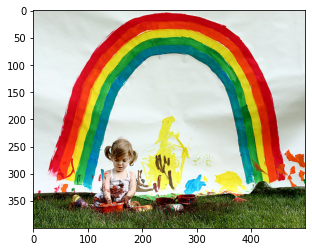

In [176]:
generate_caption("1002674143_1b742ab4b8.jpg")

---------------------Actual---------------------
 collage of one person climbing cliff 
 group of people are rock climbing on rock climbing wall 
 group of people climbing rock while one man belays 
 seven climbers are ascending rock face whilst another man stands holding the rope 
 several climbers in row are climbing the rock while the man in red watches and holds the line 
--------------------Predicted--------------------
 two people are climbing rock eos eos eos eos eos eos eos eos eos eos eos eos eos eos eos eos eos eos eos eos eos eos eos eos eos and headlamp watches eos 


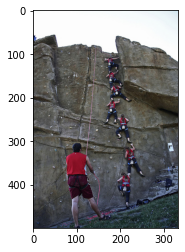

In [178]:
generate_caption("1016887272_03199f49c4.jpg")

---------------------Actual---------------------
 man is standing in front of skyscraper 
 man stands in front of skyscraper 
 man stands in front of very tall building 
 behind the man in red shirt stands large skyscraper 
 there is skyscraper in the distance with man walking in front of the camera 
--------------------Predicted--------------------
 man in black jacket standing on the street eos eos eos eos eos eos eos eos eos eos eos eos eos eos eos eos eos eos eos eos eos eos eos eos eos eos 


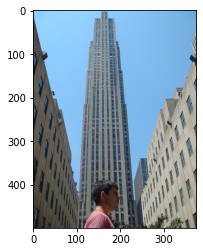

In [179]:
generate_caption("1032460886_4a598ed535.jpg")